In [1]:
%env DISPLAY=:0.0
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=16
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1

env: DISPLAY=:0.0
env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=16
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import arviz
from cmdstanpy import cmdstan_path, CmdStanModel
import cmdstanpy
%matplotlib inline

import zusammen

Configuration read from /Users/fran/.threeML/threeML_config.yml


## cosmogrb -> Stan

In [3]:
import sys
sys.path.append("../zusammen/utils")
from sim2fits import AnalysisBuilder
#from zusammen.utils.sim2fits import AnalysisBuilder

SynthGRB_0


2020-12-20 21:26:38 Francescas-MacBook-Pro.local astropy[91331] WARNING VerifyWarning: Card is too long, comment will be truncated.
2020-12-20 21:26:38 Francescas-MacBook-Pro.local astropy[91331] WARNING AstropyDeprecationWarning: "clobber" was deprecated in version 2.0 and will be removed in a future version. Use argument "overwrite" instead.

WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n0.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.5535664558410645)




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n3.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.248310565948486)




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_n2.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.631927967071533)




WARNING UserWarning: The TTE file SynthGRB_0/tte_SynthGRB_0_b1.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'







SynthGRB_1


2020-12-20 21:26:45 Francescas-MacBook-Pro.local astropy[91331] WARNING VerifyWarning: Card is too long, comment will be truncated.
2020-12-20 21:26:45 Francescas-MacBook-Pro.local astropy[91331] WARNING AstropyDeprecationWarning: "clobber" was deprecated in version 2.0 and will be removed in a future version. Use argument "overwrite" instead.

WARNING UserWarning: The TTE file SynthGRB_1/tte_SynthGRB_1_n6.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'




WARNING UserWarning: The TTE file SynthGRB_1/tte_SynthGRB_1_n8.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.910734176635742)




WARNING UserWarning: The TTE file SynthGRB_1/tte_SynthGRB_1_nb.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.372635364532471)




WARNING UserWarning: The TTE file SynthGRB_1/tte_SynthGRB_1_b1.fits contains duplicate time tags and is thus invalid. Contact the FSSC 


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'




WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX' 'SPECRESP MATRIX'


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.5535664558410645)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.631927967071533)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.248310565948486)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.5535664558410645)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.631927967071533)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.248310565948486)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.5535664558

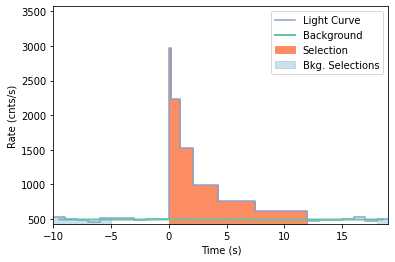

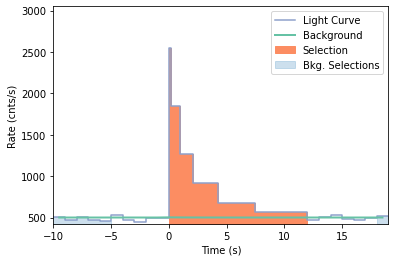

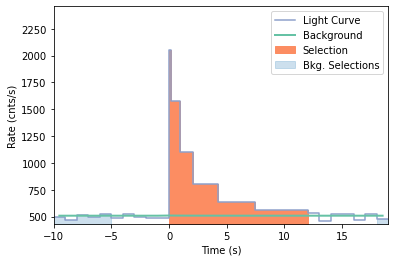

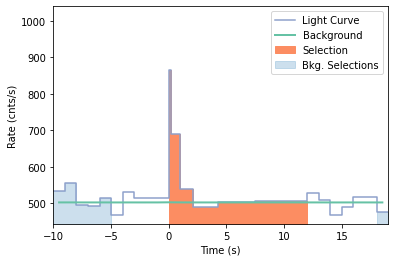

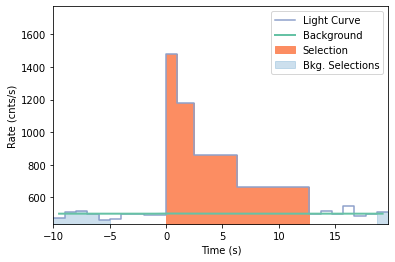

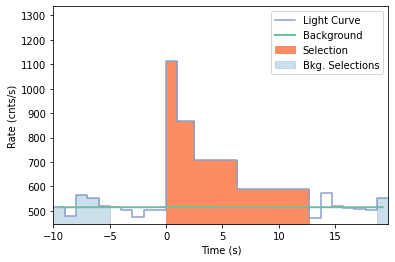

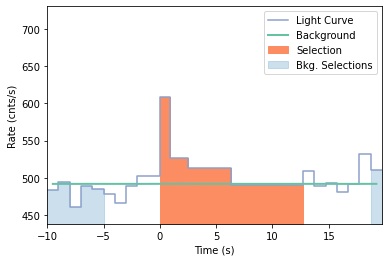

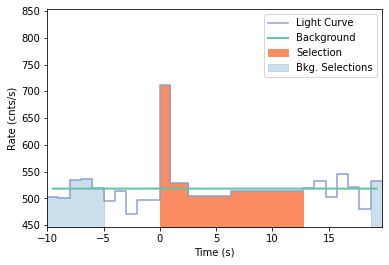

In [4]:
analysis_builder = AnalysisBuilder("data/grb_pop_survey.h5", use_bb=True, 
                                   select_grbs=None)
output = zusammen.DataSet.from_dict(analysis_builder.yaml_params)
output.to_hdf5_file("data/grb_pop_proc.h5")

## Fit

In [5]:
ds = zusammen.DataSet.from_hdf5_file('data/grb_pop_proc.h5')

In [6]:
warmup = 500
samps = 250
total = warmup + samps
chains = 4

In [7]:
model = CmdStanModel(stan_file="stan/simple_cor.stan", 
                     cpp_options={'STAN_THREADS': 'TRUE'})

2020-12-20 21:26:54 Francescas-MacBook-Pro.local cmdstanpy[91331] INFO found newer exe file, not recompiling
2020-12-20 21:26:54 Francescas-MacBook-Pro.local cmdstanpy[91331] INFO compiled model file: /Users/fran/projects/zusammen/examples/stan/simple_cor


In [8]:
data = ds.to_stan_dict()
print('N_intervals:', data['N_intervals'])
data['grb_id']

N_intervals: 10


array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [9]:
os.environ["STAN_NUM_THREADS"] = "8"

data = ds.to_stan_dict()
# TODO: Fix in ogip2stan
data["response"] = data["response"].transpose(0, 1, 3, 2)
cmdstanpy.utils.jsondump("test_data.json", data)

fit = model.sample(
    data=data,
    cores=8, 
    iter_warmup=warmup,
    iter_sampling=samps,
    chains=chains,
    show_progress="notebook", 
    seed=123)

av = arviz.from_cmdstanpy(fit)

In [10]:
#fit.summary

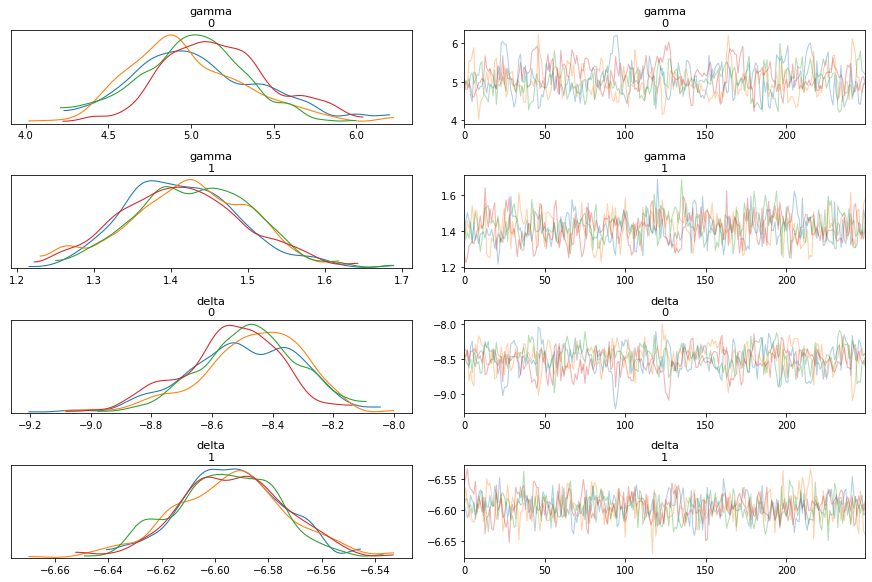

In [11]:
arviz.plot_trace(av, var_names=["gamma", "delta"]);

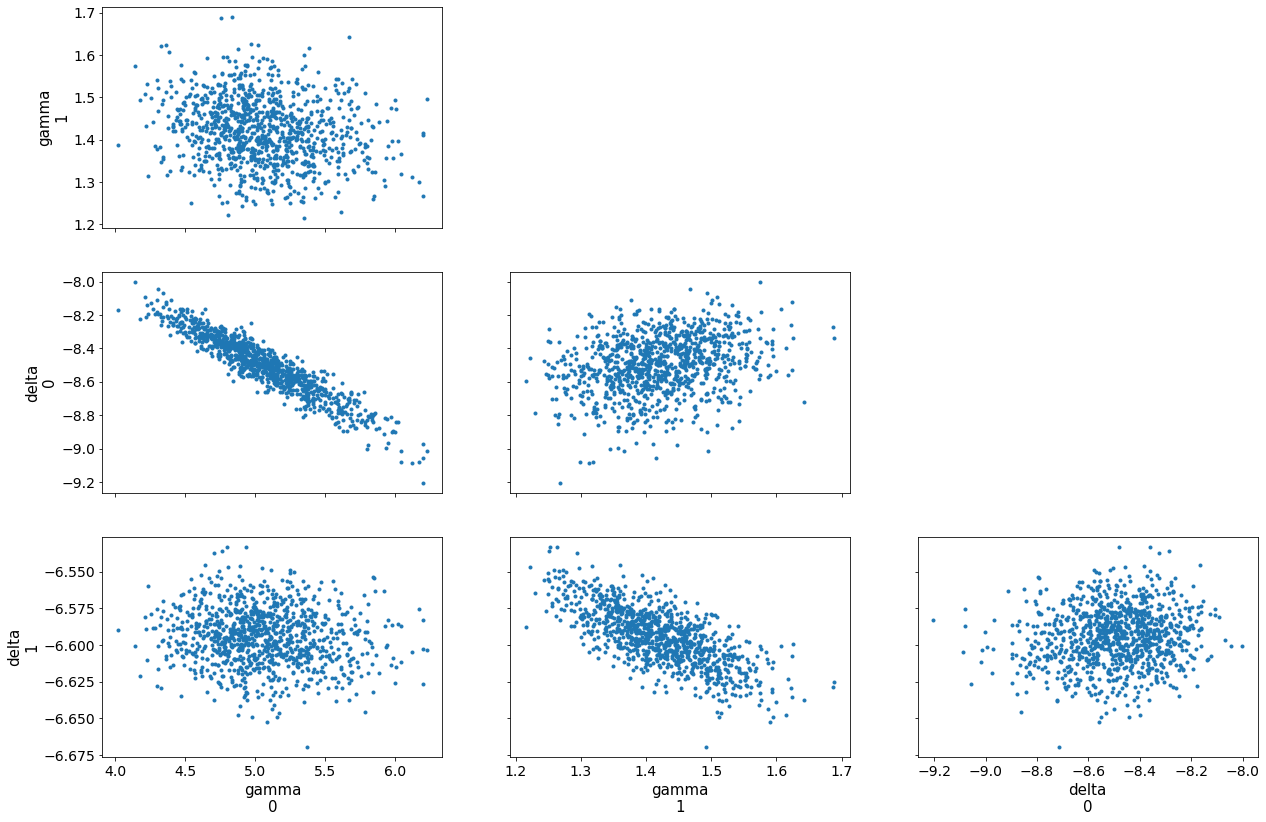

In [12]:
arviz.plot_pair(av, var_names=["gamma", "delta"], divergences=True);

### Compare with truth

In [13]:
from cosmogrb.universe.survey import Survey
from popsynth.distributions.cosmological_distribution import luminosity_distance

In [14]:
survey = Survey.from_file('data/grb_pop_survey.h5')

In [15]:
grbs = [survey[name].grb for name in survey]
gammas = [grb._source_params["gamma"] for grb in grbs]
Nrests = [grb._source_params["Nrest"] for grb in grbs]
alphas = [grb._source_params["alpha"] for grb in grbs]
ep_starts = [grb._source_params["ep_start"] for grb in grbs]
redshifts = [grb.z for grb in grbs]
dls = [luminosity_distance(z) for z in redshifts]
deltas = [np.log10(Nrest / (4*np.pi * dl**2)) for Nrest, dl in zip(Nrests, dls)]

In [16]:
N_intervals = np.shape(av.posterior.alpha)[-1]
N_grbs = len(grbs)
grb_id = np.array(data["grb_id"]) - 1
grb_colors = plt.cm.viridis(np.linspace(0.2, 0.8, N_grbs))

Text(0, 0.5, 'log_energy_flux')

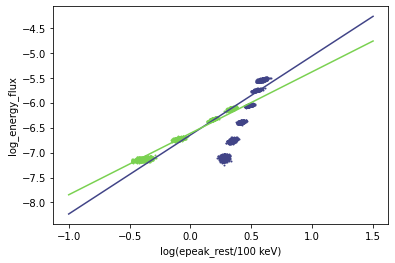

In [17]:
fig, ax = plt.subplots()

for i in range(N_intervals):

    log_epeak_rest = np.log10(10**np.concatenate(av.posterior.log_epeak[:,:,i]) 
                              * (1+redshifts[grb_id[i]]) / 100)
    ax.scatter(log_epeak_rest,
               np.concatenate(av.posterior.log_energy_flux[:,:,i]), s=1, 
               color=grb_colors[grb_id[i]])
    
xx = np.linspace(-1, 1.5, 50)
for i in range(N_grbs):
    ax.plot(xx, gammas[i] * xx + deltas[i], color=grb_colors[i])
ax.set_xlabel("log(epeak_rest/100 keV)")
ax.set_ylabel("log_energy_flux")

Text(0.5, 0, 'log_epeak')

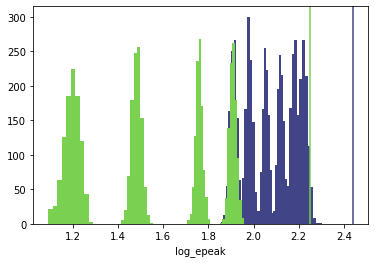

In [18]:
fig, ax = plt.subplots()
for i in range(N_intervals):
    ax.hist(np.concatenate(av.posterior.log_epeak[:,:,i]), 
            color=grb_colors[grb_id[i]]) 
for i in range(N_grbs):
    ax.axvline(np.log10(ep_starts[i]), color=grb_colors[i])
ax.set_xlabel("log_epeak")

Text(0, 0.5, 'alpha')

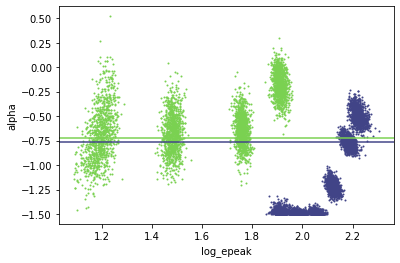

In [19]:
fig, ax = plt.subplots()
for i in range(N_intervals):
    ax.scatter(np.concatenate(av.posterior.log_epeak[:,:,i]),
               np.concatenate(av.posterior.alpha[:,:,i]), s=1, 
               color=grb_colors[grb_id[i]])
for i in range(N_grbs):
    ax.axhline(alphas[i], color=grb_colors[i])
#ax.axvline(np.log10(ep_start))
ax.set_xlabel("log_epeak")
ax.set_ylabel("alpha")

[Text(0, 0.5, 'alpha'), Text(0.5, 0, 'log energy flux')]

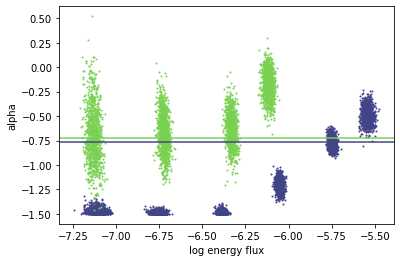

In [20]:
fig, ax = plt.subplots()

for i in range(N_intervals):
    ax.scatter(np.concatenate(av.posterior.log_energy_flux[:,:,i]),
               np.concatenate(av.posterior.alpha[:,:,i]), s=1, 
               color=grb_colors[grb_id[i]])
for i in range(N_grbs):
    ax.axhline(alphas[i], color=grb_colors[i])
ax.set(xlabel="log energy flux", ylabel="alpha")

In [21]:
#av.posterior.to_netcdf("output/simple_cor_fail.nc")